# Machine Learning Notebook - Matt

In [1]:
%matplotlib inline
import HelperFunctions as hf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [2]:
#Load in the raw data
calendar_df = hf.load_calendar_data()
prices_df = hf.load_sell_price_data()
sales_df = hf.load_sales_train_validation_data()

## Clean Data

In [94]:
#Clean the raw data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1300, items=1000, dropNAPrices=True)

## Feature Engineering

In [95]:
df = hf.priceDifference(df)

In [96]:
df = hf.rollingPriceDifference(df, windowsize=7)

In [97]:
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1)#Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=14, shift=1)
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=7)
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=28)

In [98]:
df = hf.rollingStdDemandFeature(df, windowSize=7, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=14, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=28, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=7, shift=28)

In [99]:
df = hf.rollingMeanWeekday(df, weeks = 3, shift = 1) #mean of previous 3 weeks (for that particular weekday)

In [100]:
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=14)
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before

In [101]:
df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [102]:
#Standardise features
cols_to_norm = ['d','wday','month','year','sell_price','rolling_mean_7_1','rolling_mean_14_1','rolling_mean_28_1','rolling_mean_7_7','rolling_mean_7_28','sold_lag_1',
                'sold_lag_7','sold_lag_14','sold_lag_28','rolling_std_7_1','rolling_std_14_1','rolling_std_28_1',
               'rolling_std_7_28','price_diff']

#cols_to_norm = ['d','wday','month','year','sell_price']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [103]:
#Create separate test set for item
df_item = df.loc[df.id == "FOODS_2_360_TX_3_validation"].copy()
df_test = df.loc[df.d > 1200/1300].copy()
df = df.loc[df.d <= 1200/1300].copy()

In [104]:
#product_ids = df.id.copy()
df.drop(['id'], axis=1, inplace=True) #Drop the id column
df_test.drop(['id'], axis=1, inplace=True) #Drop the id column
df_item.drop(['id'], axis=1, inplace=True) #Drop the id column

In [105]:
df.isnull().sum()

d                    0
sold                 0
wday                 0
month                0
year                 0
snap_CA              0
snap_TX              0
snap_WI              0
sell_price           0
Cultural             0
National             0
Religious            0
Sporting             0
NoEvent              0
Christmas            0
weekend              0
midweek              0
monfri               0
FOODS_1              0
FOODS_2              0
FOODS_3              0
HOBBIES_1            0
HOBBIES_2            0
HOUSEHOLD_1          0
HOUSEHOLD_2          0
FOODS                0
HOBBIES              0
HOUSEHOLD            0
CA_1                 0
CA_2                 0
CA_3                 0
CA_4                 0
TX_1                 0
TX_2                 0
TX_3                 0
WI_1                 0
WI_2                 0
WI_3                 0
CA                   0
TX                   0
WI                   0
price_diff           0
price_increase       0
price_decre

In [7]:
df.shape

(808600, 41)

In [8]:
df.columns

Index(['d', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'Cultural', 'National', 'Religious', 'Sporting',
       'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri', 'FOODS_1',
       'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1',
       'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1', 'CA_2', 'CA_3',
       'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'CA', 'TX',
       'WI'],
      dtype='object')

# Machine Learning

## Train/Test Split
We also isolate the target variables from the features

In [106]:
#Isolate features and target variable
y = df.sold.values
X_df = df.drop(['sold'], axis=1)
X = X_df.values

In [107]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [108]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(623339, 59)
(623339,)
(155835, 59)
(155835,)


## Linear Regression
The results of fitting a linear regression model on the data and analysing the feature's p-values raises some interesting findings. 
* Amongst the event related features only cultural and xmas are significant. As expected, Xmas is the most influential feature of them all.  
* The LR also confirms our findings in analysis that weekend/monfri/midweek are all significant features for predicting sales volume. 
* CA_4 and CA_3 is the only store that is an insignificant predictor. Perhaps higher population in this area?
* The mean of sold items in the week leading up is the second most influential feature.
* More expensive items sell in lower quantities

In [17]:
mod = sm.OLS(df['sold'], df[X_df.columns])
#mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   sold   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2566.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:13:04   Log-Likelihood:            -2.2468e+06
No. Observations:              808600   AIC:                         4.494e+06
Df Residuals:                  808568   BIC:                         4.494e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
d              -8.9833      1.224     -7.336      

In [18]:
lr_feature_imp = pd.DataFrame(res.params).reset_index()
lr_feature_imp.columns = ['feature','importance']
lr_feature_imp.importance = np.absolute(lr_feature_imp.importance)
lr_feature_imp = lr_feature_imp.sort_values(by=['importance'], ascending=True).reset_index(drop=True)
lr_feature_imp

,feature,importance
0,snap_CA,0.019191
1,Sporting,0.020822
2,Religious,0.025353
3,NoEvent,0.032322
4,snap_TX,0.049111
5,WI_1,0.049244
6,wday,0.051864
7,snap_WI,0.104337
8,CA_2,0.121662
9,National,0.122007


In [32]:
###Train test split
###Normalise features
###More Data Analysis
###Feature Extraction - average of weekday - exponential averages - Eve Events
###Modelling
###Feature selection - Linear Regression/RandomForests/Lasso/Correlation plots

## Decision Tree Regression - Feature Importance

In [13]:
from sklearn.tree import DecisionTreeRegressor
dc = DecisionTreeRegressor(max_depth=10, random_state=0).fit(X, y)

In [14]:
features = np.array(df.columns)
features = np.delete(features, [1])
feature_imp = pd.DataFrame({'feature': features, 'importance': dc.feature_importances_})
feature_imp = feature_imp.sort_values(by=['importance'], ascending=True).reset_index(drop=True)

In [15]:
feature_imp

,feature,importance
0,HOUSEHOLD,0.000000
1,Christmas,0.000000
2,Sporting,0.000003
3,HOBBIES_1,0.000017
4,NoEvent,0.000064
5,HOBBIES,0.000166
6,Religious,0.000224
7,monfri,0.000297
8,midweek,0.000358
9,Cultural,0.000428


In [36]:
import matplotlib 
#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 
font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

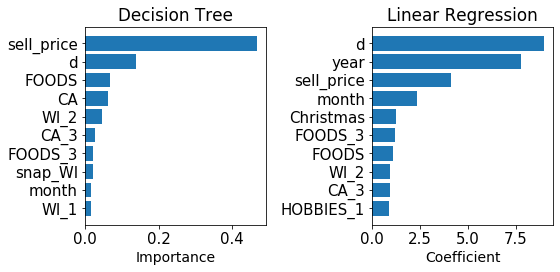

In [39]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].barh(feature_imp.feature[30:], feature_imp.importance[30:])
ax[0].set_title('Decision Tree')
ax[0].set_xlabel('Importance')
ax[1].barh(lr_feature_imp.feature[30:], lr_feature_imp.importance[30:])
ax[1].set_title('Linear Regression')
ax[1].set_xlabel('Coefficient')
plt.tight_layout()
plt.savefig('images/featureimportance.png', dpi=500)
plt.show()

## Support Vector Regression
Due to the size of the dataset we can only really use LinearSVR here, since our dataset is too large to make nonlinear SVR's viable

In [109]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [21]:
#Initial try at SVR
svm_reg = LinearSVR(epsilon=0.4, C=0.4, random_state=21)
svm_reg.fit(X_train, y_train)

KeyboardInterrupt: 

In [42]:
#Grid Search SVR
parameters = {
    'epsilon': [0.2, 0.4],
    'C': [0.1, 0.4]
}
model = LinearSVR()
clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=1000,
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.4], 'epsilon': [0.2, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [44]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.958821,0.025446,0.009581,0.000529,0.1,0.2,"{'C': 0.1, 'epsilon': 0.2}",-7.512782,-7.186471,-6.468062,-7.055773,0.436403,3
1,2.504628,0.010741,0.009673,0.001280,0.1,0.4,"{'C': 0.1, 'epsilon': 0.4}",-7.554937,-7.220711,-6.494918,-7.090190,0.442483,4
2,7.982620,0.106887,0.008579,0.000023,0.4,0.2,"{'C': 0.4, 'epsilon': 0.2}",-7.265266,-6.949928,-6.255557,-6.823585,0.421782,1
3,6.143120,0.100372,0.008617,0.000074,0.4,0.4,"{'C': 0.4, 'epsilon': 0.4}",-7.286887,-6.963951,-6.263851,-6.838230,0.427009,2


In [45]:
clf.best_params_

{'C': 0.4, 'epsilon': 0.2}

In [114]:
#Fit model with the best hyper-parameters
svm_reg = LinearSVR(epsilon=0.2, C=0.4, random_state=22)
svm_reg.fit(X_train, y_train)

LinearSVR(C=0.4, epsilon=0.2, random_state=22)

In [23]:
#Cross validation scoring metric
cv_score = cross_val_score(svm_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Mean Squared Error CV:", -np.mean(cv_score))

Mean Squared Error CV: 6.787131686368653


In [24]:
preds_train = svm_reg.predict(X_train)
preds_test = svm_reg.predict(X_test)
print(mean_squared_error(y_train, preds_train))
print(mean_squared_error(y_test, preds_test))

6.775330130679082
6.847785314466136


In [25]:
#Coefficient of determination, R2
print(svm_reg.score(X_train, y_train))
print(svm_reg.score(X_test, y_test))

0.5933483357655558
0.5997087616722856


In [28]:
preds_test

array([ 0.21794484, -0.10626046,  6.24359455, ...,  0.02372039,
        0.15304131,  0.29812693])

In [115]:
#df_item
df_item_test = df_item.loc[df_item.d > 1200/1300].copy()
y_item = df_item_test.sold.values
X_item = df_item_test.drop(['sold'], axis=1).values

In [116]:
item_preds = svm_reg.predict(X_item)
item_preds

array([18.71313488, 18.81024612, 18.21680093, 16.45870224, 17.15249534,
       16.59244266, 16.6053022 , 13.36105618, 15.24234847, 15.9283486 ,
       17.00968125, 15.88123359, 13.36588718, 14.99871109, 14.08270838,
       14.45728138, 15.9660591 , 17.07050993, 17.61710494, 17.14398647,
       17.5836774 , 16.13126842, 21.81406529, 16.29855178, 17.66628857,
       17.99375836, 16.85418505, 16.24820375, 18.88492855, 17.57199734,
       19.31156229, 17.48215794, 18.76703243, 13.96786374, 12.02361968,
       11.53609972, 10.10224126,  9.16339915,  7.73322905,  8.45548388,
        9.171119  ,  9.73405409, 10.15289597,  9.86729054,  9.92664216,
       12.63778459, 12.05781276, 14.45529898, 17.32689604, 15.51661042,
       15.98967309, 17.1807162 , 19.99010415, 21.327314  , 20.06654512,
       20.34994002, 17.92222711, 19.6705983 , 20.42387111, 19.59239901,
       19.77377146, 18.61251548, 20.51485931, 20.9768989 , 20.1139682 ,
       20.51352496, 20.62464683, 20.30008749, 19.95856843, 19.24

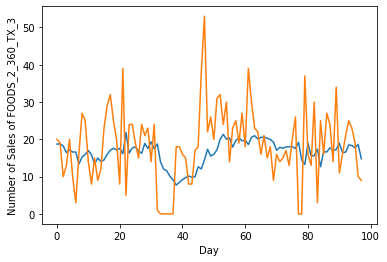

In [117]:
plt.plot(item_preds)
plt.plot(y_item)
plt.xlabel("Day")
plt.ylabel("Number of Sales of FOODS_2_360_TX_3")
plt.show()

In [118]:
#df_test
y_test = df_test.sold.values
X_test = df_test.drop(['sold'], axis=1).values

In [119]:
test_preds = svm_reg.predict(X_test)
test_preds

array([ 0.29948603,  0.02286488,  0.05146779, ...,  0.42843536,
       -0.01839655, -0.04981716])

In [120]:
mean_squared_error(y_test, test_preds)

5.9556587276026365

In [121]:
df_test['preds'] = test_preds

In [122]:
mean_squared_error(df_test[df_test['FOODS'] == 1].sold.values, df_test[df_test['FOODS'] == 1].preds.values)

10.625602792058839

In [123]:
mean_squared_error(df_test[df_test['HOUSEHOLD'] == 1].sold.values, df_test[df_test['HOUSEHOLD'] == 1].preds.values)

1.5938918151983337

In [124]:
mean_squared_error(df_test[df_test['HOBBIES'] == 1].sold.values, df_test[df_test['HOBBIES'] == 1].preds.values)

3.487299920427689

In [126]:
mean_squared_error(df_test[df_test['CA'] == 1].sold.values, df_test[df_test['CA'] == 1].preds.values)

5.460979107030518

In [127]:
mean_squared_error(df_test[df_test['TX'] == 1].sold.values, df_test[df_test['TX'] == 1].preds.values)

3.18169471462382

In [128]:
mean_squared_error(df_test[df_test['WI'] == 1].sold.values, df_test[df_test['WI'] == 1].preds.values)

9.432205096333012

## Elastic Net
Elastic Net is a linear regression model that incorporates both l1 and l2 regularisation.

In [130]:
from sklearn.linear_model import ElasticNet

Firstly, fit the model with default hyperparameters, alpha=1, l1_ratio=0.5. We can see that the MSE is much higher than for SVR

In [17]:
en = ElasticNet(alpha=1, l1_ratio = 0.5, random_state=101)
en.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=101, selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
#Cross validation scoring metric
cv_score_en = cross_val_score(en, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean Squared Error CV:", -np.mean(cv_score_en))

Mean Squared Error CV: 16.871055514922304


Cross validated grid search over several potential hyperparameters. The best hyperparameter set found is alpha=0.1, l1_ratio=0.1. l1_ratio being close to zero suggests that the model does not like to suppress any/many features to zero coeff.

In [20]:
#Grid Search SVR
parameters_en = {
    'alpha': [0.1, 1,10],
    'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]
}
eNet = ElasticNet()
en_gs = GridSearchCV(eNet, parameters_en, scoring='neg_mean_squared_error', cv=5)
en_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.1, 1, 10],
                         'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [21]:
en_gs.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

Refit the final model using the best hyperparameter set, gives MSE of 15.35.

In [131]:
en = ElasticNet(alpha=0.1, l1_ratio = 0.1, random_state=102)
en.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=102)

In [28]:
#Cross validation scoring metric
cv_score_en = cross_val_score(en, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean Squared Error CV:", -np.mean(cv_score_en))

Mean Squared Error CV: 14.682647916765845


In [133]:
item_preds = en.predict(X_item)
item_preds

array([12.2879715 , 14.3822508 , 18.00463476, 15.88481267, 18.87832305,
       15.32846894, 18.23851001, 13.73430201, 15.96283212, 15.09006999,
       14.29791222, 15.43577278, 10.82377791, 10.03139908, 16.38082979,
       12.25449505, 14.02747778, 12.28448256,  9.75441324, 12.60667166,
       16.18119152, 12.07357404, 16.95803045, 17.58018701, 12.32111017,
       13.51271042, 10.09414343, 15.19747458, 15.19977224, 15.48906299,
       21.26157159, 11.51515543, 17.29166296, 20.6193409 , 15.58927055,
        8.70578853, 17.28143623, 18.25451265, 10.57468821,  8.80595208,
        9.75832463, 13.99441964, 13.20049314, 10.65994223,  8.72267904,
       13.48819897, 13.83381522,  5.63682034, 15.47704076, 11.28760876,
       16.8245021 ,  9.46168747, 13.1714022 , 18.46806139, 11.50654677,
       11.81979471, 12.74393688, 21.92973075, 15.49533527,  9.58893815,
       15.7921554 , 12.55492632, 20.63594312, 23.28355859, 13.06836718,
       18.28088815, 18.01514458, 15.18600439, 14.01695913, 14.54

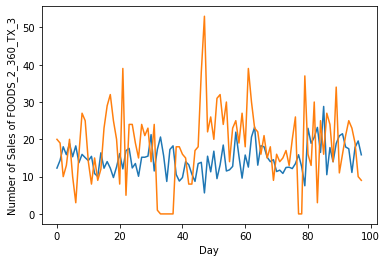

In [134]:
plt.plot(item_preds)
plt.plot(y_item)
plt.xlabel("Day")
plt.ylabel("Number of Sales of FOODS_2_360_TX_3")
plt.show()

In [135]:
test_preds = en.predict(X_test)
test_preds

array([0.70056555, 0.11317992, 0.47763285, ..., 0.82278163, 0.29149211,
       0.13033873])

In [136]:
df_test['preds'] = test_preds

In [137]:
mean_squared_error(df_test[df_test['FOODS'] == 1].sold.values, df_test[df_test['FOODS'] == 1].preds.values)

13.33254878015899

In [138]:
mean_squared_error(df_test[df_test['HOUSEHOLD'] == 1].sold.values, df_test[df_test['HOUSEHOLD'] == 1].preds.values)

1.954538674622173

In [139]:
mean_squared_error(df_test[df_test['HOBBIES'] == 1].sold.values, df_test[df_test['HOBBIES'] == 1].preds.values)

3.91792566359059

In [140]:
mean_squared_error(df_test[df_test['CA'] == 1].sold.values, df_test[df_test['CA'] == 1].preds.values)

6.831283443492722

In [141]:
mean_squared_error(df_test[df_test['TX'] == 1].sold.values, df_test[df_test['TX'] == 1].preds.values)

3.9315829134854

In [142]:
mean_squared_error(df_test[df_test['WI'] == 1].sold.values, df_test[df_test['WI'] == 1].preds.values)

11.561918948499104